# Hyperparameter Tuning Tutorial

Machine learning models often have many hyperparameters that need to be tuned to achieve maximal performance (e.g: learning rate, dropout rate, number of layers, layer size, etc) . This motivates the need for hyperparameter tuners that intelligently search the space of hyperparameters for a high performing model. 

To address this, MeTaL supports multiple hyperparameter tuners with an easy to use interface which allows users to streamline the hyperparameter optimization process. This tutorial covers utilizing MeTaL's hyperparameter tuners to tune an EndModel for maximal performance. Currently, two hyperparameter algorithms are supported:

- <b>Random Search</b>
- <b>Hyperband</b>

The tutorial is broken down into the following sections 

1. <b>Setting up the Problem and Loading the Data</b>
2. <b>Defining the Search Space</b>
3. <b>Performing Random Search</b>
4. <b>Performing Hyperband Search</b>
5. <b>Comparing Random Search against Hyperband Search</b>

Let's begin!

## Setup
Before beginning, we first need to make sure that the metal/ directory is on our Python path. If the following cell runs without an error, you're all set. If not, make sure that you've installed snorkel-metal with pip or conda (or that you've added the repo to your path if you're running from source; for example, running source add_to_path.sh from the repository root).

In [1]:
import matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import metal

/dfs/scratch0/maxlam/metal/metal/analysis.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/dfs/scratch0/maxlam/local_software/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/dfs/scratch0/maxlam/local_software/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/dfs/scratch0/maxlam/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/dfs/scratch0/maxlam/env3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/dfs/scratch0/maxlam/env3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 4

## Setting up the Problem and Loading the Data

First let's set up our problem and load our data. For the purposes of this tutorial (and to keep the search process short) we will use the small model introduced in the basic tutorial. 

In [2]:
# Load basic tutorial data
from metal.utils import split_data
import pickle

with open("data/basics_tutorial.pkl", 'rb') as f:
    X, Y, L, D = pickle.load(f)
    
Xs, Ys, Ls, Ds = split_data(X, Y, L, D, splits=[0.8, 0.1, 0.1], stratify_by=Y, seed=123)

Let's define and train our label model like in the basic tutorial.

In [3]:
# Train a the label model
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)

label_model.train(Ls[0], Y_dev=Ys[1], n_epochs=1000, print_every=250, lr=0.01, l2=1e-1)
score = label_model.score(Ls[1], Ys[1])
scores = label_model.score(Ls[1], Ys[1], metric=['precision', 'recall', 'f1'])

from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
scores = mv.score(Ls[1], Ys[1], metric=['accuracy', 'precision', 'recall', 'f1'])
Y_train_ps = label_model.predict_proba(Ls[0])

Computing O...
Estimating \mu...
[E:0]	Train Loss: 6.036
[E:250]	Train Loss: 0.029
[E:500]	Train Loss: 0.029
[E:750]	Train Loss: 0.029
[E:999]	Train Loss: 0.029
Finished Training
Accuracy: 0.879
Precision: 0.771
Recall: 0.724
F1: 0.746
Accuracy: 0.836
Precision: 0.623
Recall: 0.841
F1: 0.716


Now let's define our EndModel and verify that it successfully runs and achieves a decent score. 

In [4]:
# Train an end model
from metal.end_model import EndModel

end_model_basic = EndModel([1000,10,2], 
                     batchnorm=True,
                     dropout=.5,
                     l2=.1,
                     
                     seed=123)

end_model_basic.train(Xs[0], Y_train_ps, Xs[1], Ys[1], l2=0.1, batch_size=256, 
                n_epochs=5, print_every=1, validation_metric='f1')


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.761
[E:0]	Train Loss: 0.561	Dev score: 0.761
Saving model at iteration 1 with best score 0.902
[E:1]	Train Loss: 0.468	Dev score: 0.902
[E:2]	Train Loss: 0.458	Dev score: 0.840
[E:3]	Train Loss: 0.451	Dev score: 0.870
[E:4]	Train Loss: 0.450	Dev score: 0.818
Restoring best model from iteration 1 with score 0.902
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    202     0    
 l=2    44     754   


Great. Notice that our F1 is around .902. In the sections below we will try to optimize the hyperparameters of this EndModel to achieve an even higher score!

## Defining the Search Space

Before starting the hyperparameter tuning process, we need to specify the space of the hyperparameters we're searching. 

For the purposes of this tutorial we search over the following hyperparameters:
- <b>n_epochs</b>: Integer representing the number of epochs to train
- <b>batchnorm</b>: Boolean representing whether to use batch-normalization
- <b>lr</b>: Float representing the learning rate for optimization
- <b>layer_out_dims</b>: The architecture of our neural network

In [5]:
search_space = {
    'n_epochs': [1, 5, 10],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-5, 1], 'scale': 'log'},
    'layer_out_dims' : [[1000,10,2], [1000, 100, 2]],
    'print_every': 5,
    'data_loader_config': [{"batch_size": 256, "num_workers": 1}],
}

Here's a breakdown of what each line in the configuration means:

- `'n_epochs': [1, 5, 10],`: This specifies that the hyperparameter tuner may train the model for either 1, 5 or 10 epochs
- `'batchnorm' : [True, False],`: This specifies that a model instantiated by the tuner may have batchnorm as either True or False
- `dropout': [0, .1, .2, .3, .4, .5]`: Like the above, this specifies that the dropout parameter of an instantiated model may be one of 0, .1, .2, .3, .4, or .5
- `'lr': {'range': [1e-5, 1], 'scale': 'log'}`: This specifies that the learning rate of the training of a model may range from 1e-5 to 1, and that the tuner samples the learning rate on a log scale
- `'layer_out_dims' : [[1000,10,2], [1000, 100, 2]]`: This specifies that upon instantiation of the model, the structure of the fully connected network can either be [1000, 10, 2] or [1000, 100, 2]; in the latter case, this means the network takes a 1000 dimensional input, has a hidden layer with 100 features and an output layer with 2 classes
- `'print_every': 5`: This specifies that the model should print status updates every 5 iterations of training.
- `'data_loader_config': [{"batch_size": 256, "num_workers": 1}],`: This specifies to use a batch of 256 for optimization

Now that our search space is defined, let's start optimizing hyperparameters!

## Performing Random Search

While simple, random search has proven to be a powerful and efficient algorithm for tuning hyperparameters (see http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf for why). Let's use the RandomSearch tuner to find a good set of hyperparameters for our EndModel. Note that although we only do hyperparameter optimization for the EndModel, the tuners may also be used to do hyperparameter optimization for LabelModels.

To start, let's import the RandomSearchTuner and instantiate our RandomSearchTuner to optimize an EndModel model.

In [6]:
from metal.tuners.random_tuner import RandomSearchTuner
rs_tuner = RandomSearchTuner(EndModel, seed=123)

Next let's define our training and validation datasets.

In [7]:
train_args = [Xs[0], Y_train_ps]
X_dev, Y_dev = Xs[1], Ys[1]

And just like that we're prepped to launch our random search! Performing the search is just as easy and requires just a single call to the `search` function.

Most of the arguments to the `search` function below are self explanatory, but there are a couple of key arguments to watch out for:
- `max_search` : This specifies the number of configurations to search over. As it is set to 20 below, this means we search over 20 random models and return the best one
- `verbose`: This specifies whether the tuner should be verbose or not and can be used to turn on/off the its logging feature

In [36]:
best_rs_model = rs_tuner.search(search_space, X_dev, Y_dev, train_args=train_args, max_search=20, metric='f1', verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 4.624229978283888e-05}
Saving model at iteration 0 with best score 0.646
[E:0]	Train Loss: 0.697	Dev score: 0.646
Saving model at iteration 1 with best score 0.725
Saving model at iteration 2 with best score 0.791
Saving model at iteration 3 with best score 0.825
Saving model at iteration 4 with best score 0.847
Saving model at iteration 5 with best score 0.885
[E:5]	Train Loss: 0.594	Dev score: 0.885
Saving model at iteration 6 with best score 0.886
Saving model at iteration 7 with best score 

Saving model at iteration 0 with best score 0.929
[E:0]	Train Loss: 0.527	Dev score: 0.929
Saving model at iteration 1 with best score 0.959
[E:5]	Train Loss: 0.377	Dev score: 0.916
[E:9]	Train Loss: 0.351	Dev score: 0.930
Restoring best model from iteration 1 with score 0.959
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    202     1    
 l=2    44     753   
F1: 0.928

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[10] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0003777251862528499}
Saving model at iteration 0 with best score 0.768
[E:0]	Train Loss: 0.689	Dev score: 0.768
Saving model at iteration 2 with best score 0.775
Saving model at iteration 3 with best score 0.877
Saving 

Saving model at iteration 0 with best score 0.769
[E:0]	Train Loss: 0.665	Dev score: 0.769
Saving model at iteration 1 with best score 0.876
Saving model at iteration 2 with best score 0.925
Saving model at iteration 3 with best score 0.934
Saving model at iteration 4 with best score 0.956
[E:4]	Train Loss: 0.552	Dev score: 0.956
Restoring best model from iteration 4 with score 0.956
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    239    38    
 l=2     7     716   
F1: 0.900

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[18] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, '

Awesome, our best random search model achieves an F1 of ~.996 which outperforms the model we had previously (F1 ~ .90). Can we do even better than random search by either attaining the same accuracy faster or achieving a higher score? The following section walks through using the <b>Hyperband</b> tuner, which recent research has shown to be more efficient than random search.

## Performing Hyperband Search

While random search performs surprisingly well, we can be more efficient if we adaptively allocate more compute resources for configurations that perform well than to those that don't. For example if a configuration seems to yield a really poor model after the first epoch of training, it's unlikely it'll perform well even after more training, so we can early-terminate the training of this configuration to save compute. This is the core idea behind the <b>Hyperband</b> algorithm which recent research has shown to outperform various algorithms including random search. (See https://arxiv.org/abs/1603.06560 if interested!)

Running Hyperband is just as easy as running random search. Let's import the HyperbandTuner and instantiate it. 

Note that there is one extra argument to initialize the HyperbandTuner:
- `hyperband_epochs_budget`: This specifies the number of total epochs of training the tuner can perform in its search for a performant model. This is used to create the Hyperband search schedule.

In [31]:
from metal.tuners.hyperband_tuner import HyperbandTuner
hb_tuner = HyperbandTuner(EndModel, hyperband_epochs_budget=200, seed=123)

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config)which specify how many configs to run andfor how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (9, 2) (3, 8) (1, 26)
Bracket 1: (3, 8) (1, 26)
Bracket 2: (3, 26)
-----------------------------------------


We can launch the Hyperband search process using the same `search` call. Note that since the Hyperband schedule already limits the amount of compute we do, we don't have to set the `max_search` argument.

In [32]:
best_hb_model = hb_tuner.search(search_space, X_dev, Y_dev, train_args=train_args, metric='f1', verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0 Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3700237151852522}
Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.994	Dev score: 0.754
[E:1]	Train Loss: 0.578	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1 Testing {'n_epochs': 2, 'batchnorm': False, 'd

Saving model at iteration 0 with best score 0.937
[E:0]	Train Loss: 0.537	Dev score: 0.937
Saving model at iteration 1 with best score 0.991
[E:5]	Train Loss: 0.426	Dev score: 0.957
[E:7]	Train Loss: 0.410	Dev score: 0.957
Restoring best model from iteration 1 with score 0.991
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   
F1: 0.984

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[10 Testing {'n_epochs': 8, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00047921510264231735}
Saving model at iteration 0 with best score 0.757
[E:0]	Train Loss: 0.562	Dev score: 0.757
Saving model at iteration 1 with best score 0.984
[E:5]	Train Loss: 0.437	Dev s

Saving model at iteration 14 with best score 0.963
Saving model at iteration 15 with best score 0.972
[E:15]	Train Loss: 0.455	Dev score: 0.972
Saving model at iteration 16 with best score 0.977
Saving model at iteration 18 with best score 0.978
Saving model at iteration 19 with best score 0.980
Saving model at iteration 20 with best score 0.981
[E:20]	Train Loss: 0.450	Dev score: 0.981
Saving model at iteration 22 with best score 0.982
[E:25]	Train Loss: 0.446	Dev score: 0.982
Restoring best model from iteration 22 with score 0.982
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    228     0    
 l=2    18     754   
F1: 0.962

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[18 Test

Awesome, we achieved an F1 ~.994, which beat our initial score of F1 ~.90 and essentially matches the score achieved by random search (F1 ~.996). The next section will compare the performances of random search and Hyperband using the logged data -- and investigate when to use which algorithm.

## Comparing Random Search against Hyperband Search

During `search`, MeTaL hyperparameter tuners track useful statistics. Currently these include
* Time elapsed
* Best score
* Best configuration

We will analyze these statistics to compare random search against Hyperband. 

First, let's extract the statistics captured by our tuners.

In [37]:
hb_stats = hb_tuner.get_run_stats()
rs_stats = rs_tuner.get_run_stats()

Let's take a look at a few of the collected datapoints

In [38]:
hb_stats[:3]

[{'time_elapsed': 1.9016749858856201,
  'best_score': 0,
  'best_config': {'n_epochs': 2,
   'batchnorm': False,
   'dropout': 0,
   'layer_out_dims': [1000, 10, 2],
   'print_every': 5,
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.3700237151852522,
   'seed': 123}},
 {'time_elapsed': 3.67757248878479,
  'best_score': 0.9556025369978859,
  'best_config': {'n_epochs': 8,
   'batchnorm': False,
   'dropout': 0.1,
   'layer_out_dims': [1000, 100, 2],
   'print_every': 5,
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.019515100267567337,
   'seed': 124}},
 {'time_elapsed': 9.00398874282837,
  'best_score': 0.9876543209876543,
  'best_config': {'n_epochs': 26,
   'batchnorm': False,
   'dropout': 0.2,
   'layer_out_dims': [1000, 100, 2],
   'print_every': 5,
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.000903579845523744,
   'seed': 127}}]

`get_run_stats` returns a list of datapoints, where each datapoint (captured by a dictionary) specifies the current elapsed timestamp, the best score achieved for that timestamp and the best hyperparameter configuration for the score.

Now that we have our data and understand its format, let's compare the performances of random search and hyperband by plotting the best scores they achieve across time!

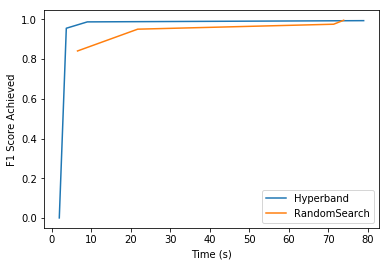

In [39]:
import matplotlib.pyplot as plt

def plot_score_vs_time(rs_data, hb_data):
    plt.cla()
    
    xs_hyperband = [x["time_elapsed"] for x in hb_data]
    ys_hyperband = [x["best_score"] for x in hb_data]
    xs_rs = [x["time_elapsed"] for x in rs_data]
    ys_rs = [x["best_score"] for x in rs_data]
    
    plt.plot(xs_hyperband, ys_hyperband, label="Hyperband")
    plt.plot(xs_rs, ys_rs, label="RandomSearch")
    
    plt.xlabel("Time (s)")
    plt.ylabel("F1 Score Achieved")
    
    plt.legend(loc="best")
    
plot_score_vs_time(rs_stats, hb_stats)

Interesting! Our plot shows that Hyperband finds a good solution very fast, much faster than random search. 

From the plot above, we see that Hyperband finds its best solution at around time 10s, whereas it takes random search around 70s to achieve a comparable score. 

The data above is very encouraging, however our previous setup may have been too simplistic. Let's make our search problem harder by expanding the search space and search time and comparing the performances of our tuners.

First let's define a harder search space.

In [51]:
harder_search_space = {
    'n_epochs': [1, 5, 10, 20, 40],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-7, 1], 'scale': 'log'},
    'layer_out_dims' : [[1000,10,2], [1000, 100, 2], [1000, 20, 2], [1000, 30, 2], [1000, 40, 2], [1000, 50, 2], [1000, 70, 2], [1000, 500, 2], [1000, 700, 2]],
    'print_every': 5,
    'data_loader_config': [{"batch_size": 256, "num_workers": 1}],
}

Next, let's create our tuners.

In [52]:
rs_tuner_harder = RandomSearchTuner(EndModel, seed=123)
hb_tuner_harder = HyperbandTuner(EndModel, hyperband_epochs_budget=800, seed=123)

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config)which specify how many configs to run andfor how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (27, 1) (9, 5) (3, 17) (1, 52)
Bracket 1: (9, 5) (3, 17) (1, 52)
Bracket 2: (6, 17) (2, 52)
Bracket 3: (4, 53)
-----------------------------------------


Then run the search process (this may take a few minutes!)

In [53]:
best_rs_model_harder = rs_tuner_harder.search(search_space, X_dev, Y_dev, train_args=train_args, max_search=20, metric='f1', verbose=True)
best_hb_model_harder =  hb_tuner_harder.search(search_space, X_dev, Y_dev, train_args=train_args, metric='f1', verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3700237151852522}
Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.994	Dev score: 0.754
[E:5]	Train Loss: 0.577	Dev score: 0.754
[E:9]	Train Loss: 0.577	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2] Te

Saving model at iteration 0 with best score 0.948
[E:0]	Train Loss: 0.605	Dev score: 0.948
Restoring best model from iteration 0 with score 0.948
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    243    58    
 l=2     3     696   
F1: 0.909

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[11] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0011538361363759827}
Saving model at iteration 0 with best score 0.983
[E:0]	Train Loss: 0.518	Dev score: 0.983
Saving model at iteration 1 with best score 0.991
[E:5]	Train Loss: 0.423	Dev score: 0.969
[E:9]	Train Loss: 0.386	Dev score: 0.938
Restoring best model from iteration 1 with score 0.991
Finished Training
Confu

Saving model at iteration 0 with best score 0.983
[E:0]	Train Loss: 0.549	Dev score: 0.983
[E:4]	Train Loss: 0.418	Dev score: 0.931
Restoring best model from iteration 0 with score 0.983
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    230     2    
 l=2    16     752   
F1: 0.960

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[20] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.003860152812810654}
Saving model at iteration 0 with best score 0.959
[E:0]	Train Loss: 0.689	Dev score: 0.959
[E:5]	Train Loss: 0.436	Dev score: 0.941
[E:9]	Train Loss: 0.424	Dev score: 0.913
Res

Saving model at iteration 0 with best score 0.911
[E:0]	Train Loss: 0.526	Dev score: 0.911
Restoring best model from iteration 0 with score 0.911
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    165     0    
 l=2    81     754   
F1: 0.814

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[8 Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008687963391291976}
Saving model at iteration 0 with best score 0.967
[E:0]	Train Loss: 0.505	Dev score: 0.967
Restoring best model from iteration 0 with score 0.967
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1   

Saving model at iteration 0 with best score 0.819
[E:0]	Train Loss: 0.939	Dev score: 0.819
Restoring best model from iteration 0 with score 0.819
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    87      0    
 l=2    159    754   
F1: 0.450

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1)
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[18 Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.14221205603963122}
Saving model at iteration 0 with best score 0.960
[E:0]	Train Loss: 0.500	Dev score: 0.960
Restoring best model from iteration 0 with score 0.960
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    212

Saving model at iteration 0 with best score 0.987
[E:0]	Train Loss: 0.573	Dev score: 0.987
Saving model at iteration 1 with best score 0.989
[E:4]	Train Loss: 0.438	Dev score: 0.941
Restoring best model from iteration 1 with score 0.989
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   
F1: 0.984

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[28 Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.006235324635557636}
Saving model at iteration 0 with best score 0.985
[E:0]	Train Loss: 0.514	Dev score: 0.985
Saving model at iteration 1 with best score 0.999
[E:4]	Train Loss: 0.432	Dev score: 0.978
Restoring best model from iteration 1 with score 0.999
Finis

Saving model at iteration 0 with best score 0.985
[E:0]	Train Loss: 0.514	Dev score: 0.985
Saving model at iteration 1 with best score 0.999
[E:5]	Train Loss: 0.423	Dev score: 0.953
[E:10]	Train Loss: 0.393	Dev score: 0.904
[E:15]	Train Loss: 0.381	Dev score: 0.892
[E:16]	Train Loss: 0.379	Dev score: 0.888
Restoring best model from iteration 1 with score 0.999
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   
F1: 0.998

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3)
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[37 Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.001266399031265807}
S

Saving model at iteration 0 with best score 0.990
[E:0]	Train Loss: 0.524	Dev score: 0.990
[E:4]	Train Loss: 0.428	Dev score: 0.968
Restoring best model from iteration 0 with score 0.990
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    238     0    
 l=2     8     754   
F1: 0.986

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[45 Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00015799041294640756}
Saving model at iteration 0 with best score 0.350
[E:0]	Train Loss: 0.743	Dev score: 0.350
Saving model at iteration 1 with best score 0.651
Saving model at iteration 2 with best score 0.729
Saving model at iteration 3 with best score 0.758
Saving model at iterati

[E:15]	Train Loss: 0.339	Dev score: 0.941
[E:20]	Train Loss: 0.329	Dev score: 0.939
[E:25]	Train Loss: 0.324	Dev score: 0.925
[E:30]	Train Loss: 0.321	Dev score: 0.931
[E:35]	Train Loss: 0.316	Dev score: 0.934
[E:40]	Train Loss: 0.315	Dev score: 0.934
[E:45]	Train Loss: 0.314	Dev score: 0.930
[E:50]	Train Loss: 0.313	Dev score: 0.933
[E:51]	Train Loss: 0.313	Dev score: 0.930
Restoring best model from iteration 0 with score 0.990
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    240     0    
 l=2     6     754   
F1: 0.986

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[53 Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0010313792236254435}
Saving model at iteration 0 with best sco

Saving model at iteration 0 with best score 0.757
[E:0]	Train Loss: 0.651	Dev score: 0.757
Saving model at iteration 3 with best score 0.772
Saving model at iteration 4 with best score 0.832
Saving model at iteration 5 with best score 0.904
[E:5]	Train Loss: 0.478	Dev score: 0.904
Saving model at iteration 6 with best score 0.951
Saving model at iteration 7 with best score 0.964
Saving model at iteration 8 with best score 0.977
Saving model at iteration 10 with best score 0.979
[E:10]	Train Loss: 0.454	Dev score: 0.979
Saving model at iteration 14 with best score 0.982
[E:15]	Train Loss: 0.448	Dev score: 0.980
[E:20]	Train Loss: 0.443	Dev score: 0.974
[E:25]	Train Loss: 0.439	Dev score: 0.977
[E:30]	Train Loss: 0.434	Dev score: 0.971
[E:35]	Train Loss: 0.430	Dev score: 0.963
[E:40]	Train Loss: 0.426	Dev score: 0.963
[E:45]	Train Loss: 0.424	Dev score: 0.952
[E:50]	Train Loss: 0.420	Dev score: 0.960
[E:51]	Train Loss: 0.420	Dev score: 0.957
Restoring best model from iteration 14 with sc

And extract and plot our data:

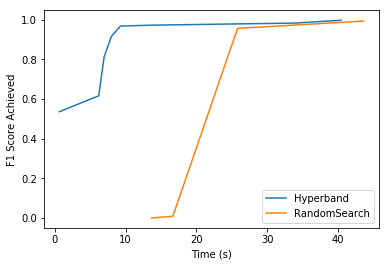

In [62]:
hb_stats_harder = hb_tuner_harder.get_run_stats()
rs_stats_harder = rs_tuner_harder.get_run_stats()
plot_score_vs_time(rs_stats_harder, hb_stats_harder)

Awesome! Generally it seems Hyperband is better in regimes with a large search space and a long search time (which is the typical scenario). 

This seems to make intuitive sense: 
- with a larger search space Hyperband's resource allocation becomes more useful in culling bad configuration
- with a longer search time Hyperband is able to start with a larger pool of configurations, enabling a better balance of exploration / exploitation

And that wraps up the hyperparameter tuning tutorial! We hope that MeTaL's hyperparameter tuners are useful for your applications and make hyperparameter tuning enjoyable. Happy tuning!